In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns

from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adamax
from tensorflow import keras
from keras.layers import Input, Dense, Embedding, Flatten, Dropout, merge, Activation, BatchNormalization, LeakyReLU, Add

from keras.models import Model
from keras.regularizers import l2
from keras import backend as K
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import initializers
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.sparse import csr_matrix
import tensorflow as tf
from sklearn import preprocessing

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd gdrive/MyDrive/RecSys_Final_Project/
caption_file = 'ratings.dat'


Mounted at /content/gdrive
/content/gdrive/MyDrive/RecSys_Final_Project


Preprocessing

In [2]:
'''
The raw data file is separated by :: without headers. So first, we will turn the raw data into a dataframe.

'''

df = open(caption_file)

rnames = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_table(df, sep='::', header=None, names=rnames, engine='python')

ratings.user_id = ratings.user_id.astype('category').cat.codes.values
ratings.movie_id = ratings.movie_id.astype('category').cat.codes.values

In [21]:
'''
- creating train,validation and test set
- make sure that splitting is accoring to the startify (by user's id)

'''

train_df, test_df = train_test_split(ratings,
                                     stratify=ratings['user_id'],
                                     test_size=0.1,
                                     random_state=42)

train_df, validate_df  = train_test_split(train_df,
                                     stratify=train_df['user_id'],
                                     test_size=0.1,
                                     random_state=42)

num_users = ratings['user_id'].unique().max() + 1
num_movies = ratings['movie_id'].unique().max() + 1



In [3]:
def df_to_numpy(df,num_users, num_items, default=3, avg=False):
  '''
    input:
      - df: the dataframe to turn into numpy array
      - num_users/items: a fixed size of the data's number of users/items
      - default: the default rating to predict a user will give if not rated some item
      - avg: condition, if True than default will be counted as average
    
    output:
      - numpy array
  '''
  
  if avg:
    temp = np.full((num_users, num_items), 0.0)
    for (_, userID, itemID, rating, timestamp) in df.itertuples():
      temp[userID, itemID] = rating
    avg = np.true_divide(temp.sum(1), np.maximum((temp!=0).sum(1), 1))
    indices = np.where(temp == 0)
    temp[indices] = np.take(avg, indices[0])
  
  else:
    temp = np.full((num_users, num_items), default)
    for (_, userID, itemID, rating, timestamp) in df.itertuples():
      temp[userID, itemID] = rating

  temp = temp.astype('float32')
  return temp

Next, we will load our training's validation and test set as numpy arrays

In [22]:
users_item_train = df_to_numpy(train_df, num_users, num_movies, default = 3)
users_item_val = df_to_numpy(validate_df, num_users, num_movies, default = 0)
users_item_test = df_to_numpy(test_df, num_users, num_movies, default = 0)

In [23]:
def get_movies_profiles(user_file, item_file):
  '''
    input:
      - user_file, item_file: location of users/items data to be opened
    
    output:
      - a movies_profile
  '''

  us = open(user_file,encoding='ISO-8859-1')
  it = open(item_file,encoding='ISO-8859-1')

  df_items = pd.read_table(it, names = ['movie_id', 'title', 'genre'], sep = "::", engine = 'python')
  df_users = users = pd.read_table(us, names = ['user_id', 'gender', 'age', 'occupation_code', 'zip'], sep = "::", engine = 'python')

  df_items['genre'] = df_items['genre'].str.split('|')
  mlb = MultiLabelBinarizer(sparse_output=True)
  df_items = df_items.join(
             pd.DataFrame.sparse.from_spmatrix(
             mlb.fit_transform(df_items.pop('genre')),
             index=df_items.index,
             columns=mlb.classes_))

  movies_profile = df_items[['movie_id','title','Action','Adventure','Animation',
                             "Children's",'Comedy','Crime','Documentary','Drama','Fantasy',
                             'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']].set_index('movie_id')
  movies_profile.sort_index(axis=0, inplace=True)


  tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english', max_features=500)
  tfidf_matrix = tf.fit_transform(movies_profile['title'])

  movies_profile = movies_profile.drop(['title'], axis=1) 
  df = movies_profile.sum()
  idf = (len(df_items)/df).apply(np.log) 
  TFIDF = movies_profile.mul(idf.values)

  titles_tfidf = pd.DataFrame(data=tfidf_matrix.todense())
  titles_tfidf.index = np.arange(1, len(titles_tfidf) + 1)

  movies_profile = pd.concat((TFIDF, titles_tfidf), axis=1)

  return movies_profile

def get_users_profiles(train, movies_profile):

  item_x_user = train.pivot_table(values = 'rating', index='movie_id', columns = 'user_id')
  item_x_user.sort_index(axis=0, inplace=True)
  item_x_user.fillna(0, inplace=True)

  userIDs = item_x_user.columns
  users_profiles = pd.DataFrame(columns = movies_profile.columns)
  for i in range(len(item_x_user.columns)):
      working_df = movies_profile.mul(item_x_user.iloc[:,i], axis=0)
      users_profiles.loc[userIDs[i]] = working_df.mean(axis=0)

  return users_profiles

def users_to_clusters(users_profiles, users_item_train, users_item_val, users_item_test, train_df, k=2):
  dataset_group = {}
  clusters = KMeans(n_clusters=k)
  clustered_users_vector = clusters.fit_predict(np.array(users_profiles))
  
  for i in range(k):
    temp_indices = np.where(clustered_users_vector == i)[0]
    temp_train = users_item_train[temp_indices]
    temp_val = users_item_val[temp_indices]
    temp_test = users_item_test[temp_indices]
    dataset_group[i] = (temp_train, temp_val, temp_test)

  return dataset_group, clustered_users_vector

def get_new_dataset(divided_dataset):
  new_dataset = {}
  for i in range(len(divided_dataset.keys())):
    new_dataset[(i,'train')], new_dataset[(i,'val')], new_dataset[(i,'test')] = divided_dataset[i]

  new_dataset['num_classes'] = len(divided_dataset.keys())

  return new_dataset

movies_profiles = get_movies_profiles( 'users.dat', 'movies.dat')
users_profiles = get_users_profiles(train_df, movies_profiles)

To prove that each user's rating is not from a fixed distribution, we will show the difference between users' profiles by using dimentionality reduction using TSNE

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)
tsne = TSNE()
X_embedded = tsne.fit_transform(users_profiles)

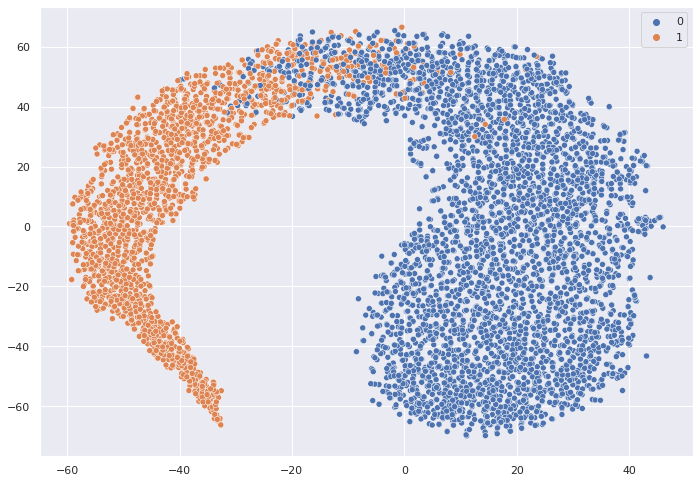

In [28]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1],legend='full')

METRICS

In [7]:
def masked_rmse(y_true, y_pred):
  '''
    input:
      - y_true, y_pred: true and predicted ratings for every batch of users
    
    output:
      - the RMSE
  '''

  y_true = tf.dtypes.cast(y_true, tf.float32)
  mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
  masked_squared_error = K.square(mask_true * (y_true - y_pred))
  masked_rmse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
  return masked_rmse

def masked_rmse_clip(y_true, y_pred):
  '''
    input:
      - y_true, y_pred: true and predicted ratings for every batch of users
    
    output:
      - the clipped RMSE
  '''
  y_true = tf.dtypes.cast(y_true, tf.float32)
  y_pred = K.clip(y_pred, 1, 5)
  mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
  masked_squared_error = K.square(mask_true * (y_true - y_pred))
  masked_rmse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
  return masked_rmse

def MRMSE_MF(y_true, y_pred):
  '''
    input:
      - y_true, y_pred: true and predicted ratings for every batch of users
    
    output:
      - the MF RMSE
  '''
  mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
  y_pred *= mask_true
  y_true = tf.dtypes.cast(y_true, tf.float32)
  return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def CMRMSE_MF(y_true, y_pred):
  '''
    input:
      - y_true, y_pred: true and predicted ratings for every batch of users
    
    output:
      - the MF clipped RMSE
  '''

  mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
  y_pred *= mask_true
  y_pred = K.clip(y_pred, 1, 5)
  y_true = tf.dtypes.cast(y_true, tf.float32)
  return K.sqrt(K.mean(K.square(y_pred - y_true))) 

  
def show_rmse(history_dict, skip=0):
  rmse = history_dict['masked_rmse_clip']
  val_rmse = history_dict['val_masked_rmse_clip']
  plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
  plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
  plt.title('model train vs validation masked_rmse')
  plt.ylabel('rmse')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()


def show_loss(history_dict, skip=0):
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']
  plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
  plt.plot(np.arange(skip, len(val_loss), 1), val_loss[skip:])
  plt.title('model train vs validation masked_rmse')
  plt.ylabel('rmse')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()
  

def plot_init_values_cmrmse(y_axis, x_label, y_label, title, labels):
  '''
    this function plots cmrmse of each model 
  '''
  colors = ['r','g','y','b','brown','pink','orange']
  fig, ax = plt.subplots()
  min_hr = 1
  max_hr = 0
  x_axis = []

  for i in range(len(y_axis)):
    if min(y_axis[i]) < min_hr:
      min_hr = min(y_axis[i])
    if max(y_axis[i]) > max_hr:
      max_hr = max(y_axis[i])
    
    x_axis.append(range(len(y_axis[i])))

  max_hr = min(10,max_hr)
  for i in range(len(y_axis)):
    ax.plot(x_axis[i], y_axis[i], color=colors[i], label=labels[i])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(min_hr-0.01, max_hr+0.1)
    plt.title(title)
    plt.legend()


MODELS SECTION

In [8]:
def get_MF_model(num_users, num_items, latent_dim):

    user_input = Input(shape=[1], name = 'user_input')
    item_input = Input(shape=[1], name = 'item_input')
    
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)   

    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    prediction = keras.layers.dot([user_latent,item_latent], axes=1,normalize=False)
    
    
    model = Model(inputs=[user_input, item_input], outputs=prediction)

    return model

In [9]:
def AutoRec_Model(X, reg, first_activation, last_activation, hidden_neurons=500):

  input_layer = Input(shape=(X.shape[1],), name='UserRating')
  x = Dense(hidden_neurons, activation=first_activation, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(input_layer)
  output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(reg))(x)
  model = Model(input_layer, output_layer)

  return model

In [10]:
class Improved_AutoRec_Model():
  
  def __init__(self, k, reg, hidden_neurons, first_activation, last_activation):
    self.hidden_neurons = hidden_neurons
    self.first_activation = first_activation
    self.last_activation = last_activation
    self.reg = reg
    self.k = k
    self.models = {}

    self.users_item_train = df_to_numpy(train_df, num_users, num_movies, default = 0)
    divided_dataset, _ = users_to_clusters(users_profiles, self.users_item_train, users_item_val, users_item_test, train_df, k=self.k)
    self.new_dataset = get_new_dataset(divided_dataset)

    for i in range(self.k):
      self.models[i] = self.get_model(self.new_dataset[(i,'train')])

  def get_model(self, X):

    input_layer = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(self.hidden_neurons, activation=self.first_activation, name='LatentSpace', kernel_regularizer=regularizers.l2(self.reg))(input_layer)
    output_layer = Dense(X.shape[1], activation=self.last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(self.reg))(x)
    model = Model(input_layer, output_layer)

    return model


First, we will try values to be initialized to the train matrix - for the item's each user hasn't predicted yet

In [ ]:
###
# list of init ratings
###
cond1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)
cond2 = tf.keras.callbacks.EarlyStopping(monitor='val_masked_rmse_clip', patience = 3)
combo = []
memory_dict = {}

results = pd.DataFrame(columns = ['Model','InitRating','Loss','CMRMSE'])

for init_rating in range(7):
  if init_rating == 6: # set as average
    users_item_train = df_to_numpy(train_df, num_users, num_movies, avg=True)
    init_rating = 'Average'
  else:
    users_item_train = df_to_numpy(train_df, num_users, num_movies, default = init_rating)

  AE_model = AutoRec_Model(users_item_train, 0.001, 'sigmoid', 'elu', 500)
  AE_model.compile(optimizer=Adam(lr=0.0001), loss = masked_rmse, metrics=[masked_rmse_clip])
  hist_AE = AE_model.fit(x=users_item_train, y=users_item_train,
                         epochs=300, batch_size=256, verbose = 1, 
                         validation_data=[users_item_val, users_item_val], callbacks=[cond1,cond2])
  
  test_eval = AE_model.evaluate(users_item_test, users_item_test, batch_size = 128)
  results.loc[len(results)] = 'AutoRec', init_rating, test_eval[0], test_eval[1]
  key = (init_rating)
  val = hist_AE.history
  memory_dict[key] = val


Hyper parameters for the baseline model - Matrix Factorization

In [ ]:
###
# HYPERPARAMETERS MF
###
cond1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)
cond2 = tf.keras.callbacks.EarlyStopping(monitor='val_CMRMSE_MF', patience = 3)
combo = []
memory_dict = {}

learning_rates = 	[5e-2,1e-2,5e-3,1e-3,5e-4,1e-4,5e-5]
hidden_dims = [4,8,16,32,64]

results = pd.DataFrame(columns = ['Model','LearningRate','HiddenDim','Loss', 'CMRMSE'])

for lr in learning_rates:
  for hd in hidden_dims:
    combo.append((lr,hd))

for hp in combo:
  lr, num_hidden = hp

  MF_model = get_MF_model(num_users, num_movies, num_hidden)
  MF_model.compile(optimizer=Adam(lr=lr), loss=MRMSE_MF, metrics=[CMRMSE_MF])

  hist_MF = MF_model.fit([train_df.user_id, train_df.movie_id],
                        train_df.rating, epochs=100, verbose = 0, batch_size = 1024,
                        validation_data=([validate_df.user_id, validate_df.movie_id],
                                          validate_df.rating), callbacks=[cond1,cond2])
  
  test_eval = MF_model.evaluate((test_df.user_id, test_df.movie_id), test_df.rating)
  results.loc[len(results)] = 'MF', lr, num_hidden, test_eval[0], test_eval[1]
  key = (lr, num_hidden)
  val = hist_MF.history
  memory_dict[key] = val
  print(f"Combination of:")
  print(f"lr = {lr}, hidden neurons = {num_hidden} Resulted:")
  print(f"Masked RMSE = {test_eval[0]}, Cliiped MRMSE {test_eval[1]}")

  np.save('MF_dict.npy',memory_dict)
  np.save('MF_df_results.npy', results)

Hyper parameters for the paper's model - Autoencoder

In [ ]:
###
# HYPERPARAMETERS AE
###
cond1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)
cond2 = tf.keras.callbacks.EarlyStopping(monitor='val_masked_rmse_clip', patience = 3)
combo = []
activate_duo = []
memory_dict = {}
i = 1
regs = [1e-3,5e-3,1e-2,5e-2,1e-1,5e-1]
hidden_dims = [50,100,300,500,1000,1500]
learning_rates = 	[5e-2,1e-2,5e-3,1e-3,5e-4,1e-4,5e-5]
activate_duo =[('sigmoid','linear'),('sigmoid','elu'),('elu','linear'),('sigmoid','sigmoid'),('elu','elu')]
results = pd.DataFrame(columns = ['Model','Regs','HiddenDim', 'LearningRate', 'FirstActivate','SecActivate','Loss','CMRMSE'])

for reg in regs:
  for hd in hidden_dims:
    for first_activation, sec_activation in activate_duo:
      for lr in learning_rates:
        combo.append((reg,hd,lr,first_activation,sec_activation))

for hp in combo:
  reg, num_hidden, lr, first_func, sec_func = hp

  AE_model = AutoRec_Model(users_item_train, reg, first_func, sec_func, num_hidden)
  AE_model.compile(optimizer=Adam(lr=lr), loss = masked_rmse, metrics=[masked_rmse_clip])
  hist_AE = AE_model.fit(x=users_item_train, y=users_item_train,
                         epochs=300, batch_size=128, verbose = 0, 
                         validation_data=[users_item_val, users_item_val], callbacks=[cond1,cond2])
  
  test_eval = AE_model.evaluate(users_item_test, users_item_test, batch_size = 128)
  results.loc[len(results)] = 'AutoRec', reg, num_hidden, lr, first_func, sec_func, test_eval[0], test_eval[1]
  key = (reg, num_hidden, lr, first_func, sec_func)
  val = hist_AE.history
  memory_dict[key] = val


Lastly, hyperparameters for our suggested improved model

In [ ]:
'''
HP Improved Model
'''

cond1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)
cond2 = tf.keras.callbacks.EarlyStopping(monitor='val_masked_rmse_clip', patience = 5)
combo = []
activate_duo = []
memory_dict = {}
models = {}
hist_IAE = {}
i = 1
regs = 	[1e-3,5e-3,1e-2,5e-2,1e-1,5e-1]
hidden_dims = [50,100,300,500,1000,1500]
learning_rates = [5e-2,1e-2,5e-3,1e-3,5e-4,1e-4,5e-5]
activate_duo = 	[('sigmoid','linear'),('sigmoid','elu'),('elu','linear'),('sigmoid','sigmoid'),('elu','elu')]
results = pd.DataFrame(columns = ['Model','#Teams','Regs','HiddenDim', 'LearningRate', 'FirstActivate','SecActivate','Loss','CMRMSE'])

for reg in regs:
  for hd in hidden_dims:
    for first_activation, sec_activation in activate_duo:
      for lr in learning_rates:
        for k in range(2,5):
          combo.append((k,reg,hd,lr,first_activation,sec_activation))

for hp in combo:
  
  k,reg, num_hidden, lr, first_func, sec_func = hp
  Improved_AE = Improved_AutoRec_Model(k,reg,num_hidden,first_func,sec_func) 

  weighted_eval = 0
  hist_temp = {}
  for i in range(k):
    Improved_AE.models[i].compile(optimizer=Adam(lr=lr), loss = masked_rmse, metrics=[masked_rmse_clip])
    batch_size = int(Improved_AE.new_dataset[(i,'train')].shape[0] / 50)
    batch_size = min(batch_size,64)
    hist_temp[i] = Improved_AE.models[i].fit(x=Improved_AE.new_dataset[(i,'train')], y=Improved_AE.new_dataset[(i,'train')],
                         epochs=300, batch_size=batch_size, verbose = 1, 
                         validation_data=[Improved_AE.new_dataset[(i,'val')], Improved_AE.new_dataset[(i,'val')]], callbacks=[cond1,cond2])

    test_eval = Improved_AE.models[i].evaluate(Improved_AE.new_dataset[(i,'test')], Improved_AE.new_dataset[(i,'test')], batch_size = batch_size)
    weighted_eval = weighted_eval + (Improved_AE.new_dataset[(i,'test')].shape[0] / num_users) * test_eval[1]

  results.loc[len(results)] = 'AutoRec', k, reg, num_hidden, lr, first_func, sec_func, test_eval[0], weighted_eval
  key = (k, reg, num_hidden, lr, first_func, sec_func)
  val = hist_temp
  memory_dict[key] = val